In [1]:
# imports
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm, naive_bayes
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.utils import shuffle
import random
import itertools

%matplotlib inline

In [2]:
# import playoffs data
data = pd.read_csv('Data/Ready_for_ML/lnab_playoff.csv')
data.set_index(['Series_ID'],inplace=True)
data.head()

,Homefield_advantage,Opponent 0,Winner,Year,Opponent 1,GF,PK SI,PK SI/GP,PK GA,PK GA/GP,...,10',GM,MP,PIM Total,PP OP,PP OP/GP,PP%,PPT,PP time/GP,Number of year
Series_ID,,,,,,,,,,,,,,,,,,,,,
0809_EV Zug Kloten Flyers,0,EV Zug,1,809,Kloten Flyers,-3.0,18.0,0.36,4.0,0.08,...,-11.0,3.0,0.0,-3.0,-20.0,-0.40,-0.20,-4586.0,-92.0,0.0
0809_EV Zug SC Bern,0,EV Zug,0,809,SC Bern,-16.0,27.0,0.54,-5.0,-0.10,...,-2.0,0.0,-1.0,8.0,39.0,0.78,-5.01,4220.0,84.0,0.0
0809_Fribourg-Gottéron HC Davos,1,Fribourg-Gottéron,1,809,HC Davos,-30.0,-25.0,-0.50,11.0,0.22,...,4.0,-1.0,1.0,20.0,24.0,0.48,-3.74,3443.0,69.0,0.0
0809_Fribourg-Gottéron ZSC Lions,1,Fribourg-Gottéron,0,809,ZSC Lions,-22.0,31.0,0.62,17.0,0.34,...,4.0,0.0,1.0,134.0,9.0,0.18,-4.81,1737.0,35.0,0.0
0809_Genève-Servette HC Kloten Flyers,1,Genève-Servette HC,1,809,Kloten Flyers,-17.0,26.0,0.52,0.0,0.00,...,0.0,0.0,2.0,120.0,-12.0,-0.24,-3.01,-3004.0,-60.0,0.0


In [3]:
# keep the first 7 season as training, keep the 2015-2016 NLA playoffs for testing
train_seasons = data.iloc[0:91,:]
test_season = data.iloc[91:,:]
test_season_lna = test_season.iloc[[2,3,4,7,8,9,13],:]
test_season_lna

,Homefield_advantage,Opponent 0,Winner,Year,Opponent 1,GF,PK SI,PK SI/GP,PK GA,PK GA/GP,...,10',GM,MP,PIM Total,PP OP,PP OP/GP,PP%,PPT,PP time/GP,Number of year
Series_ID,,,,,,,,,,,,,,,,,,,,,
1516_EV Zug HC Lugano,1,EV Zug,1,1516,HC Lugano,4.0,9.0,0.18,1.0,0.02,...,3.0,0.0,0.0,28.0,6.0,0.12,5.65,598.0,12.0,0.0
1516_Fribourg-Gottéron Genève-Servette HC,1,Fribourg-Gottéron,1,1516,Genève-Servette HC,-12.0,-42.0,-0.84,6.0,0.12,...,0.0,1.0,0.0,-31.0,22.0,0.44,-4.84,1069.0,21.0,0.0
1516_Genève-Servette HC HC Lugano,1,Genève-Servette HC,1,1516,HC Lugano,3.0,28.0,0.56,2.0,0.04,...,4.0,-1.0,0.0,42.0,-14.0,-0.28,8.74,-1173.0,-23.0,0.0
1516_HC Davos Kloten Flyers,0,HC Davos,0,1516,Kloten Flyers,27.0,22.0,0.44,-13.0,-0.26,...,7.0,5.0,0.0,238.0,17.0,0.34,-3.26,934.0,19.0,0.0
1516_HC Davos SC Bern,0,HC Davos,1,1516,SC Bern,29.0,0.0,0.00,-11.0,-0.22,...,3.0,3.0,0.0,58.0,-36.0,-0.72,-5.31,-2058.0,-41.0,0.0
1516_HC Lugano SC Bern,0,HC Lugano,1,1516,SC Bern,5.0,-11.0,-0.22,-4.0,-0.08,...,-6.0,3.0,0.0,-30.0,-23.0,-0.46,-7.66,-1329.0,-27.0,0.0
1516_SC Bern ZSC Lions,1,SC Bern,0,1516,ZSC Lions,-21.0,20.0,0.40,1.0,0.02,...,6.0,1.0,0.0,174.0,33.0,0.66,-1.08,2461.0,49.0,0.0


In [4]:
train_seasons.columns

Index(['Homefield_advantage', 'Opponent 0', 'Winner', 'Year', 'Opponent 1',
       'GF', 'PK SI', 'PK SI/GP', 'PK GA', 'PK GA/GP', 'PK%', 'PKT',
       'PK time/GP', 'SHG', 'PK GF/GP', 'GF/GP', 'GA', 'GA/GP', 'GF even',
       'GF even/GP', 'GA even', 'GA even/GP', 'PPG', 'PPG/GP', 'PP GA',
       'PP GA/GP', 'SOWGF', 'SOWGA', '2' ', '5'', '10'', 'GM', 'MP',
       'PIM Total', 'PP OP', 'PP OP/GP', 'PP%', 'PPT', 'PP time/GP',
       'Number of year'],
      dtype='object')

In [28]:
# prepare data for ML
y_train = train_seasons['Winner'].as_matrix()
X_train = train_seasons.drop(['Opponent 0', 'Winner', 'Year', 'Opponent 1'], axis=1).as_matrix()
X_train_norm = MinMaxScaler().fit_transform(X_train)
y_test = test_season_lna['Winner'].as_matrix()
X_test = test_season_lna.drop(['Opponent 0', 'Winner', 'Year', 'Opponent 1'], axis=1).as_matrix()
X_test_norm = MinMaxScaler().fit_transform(X_test)

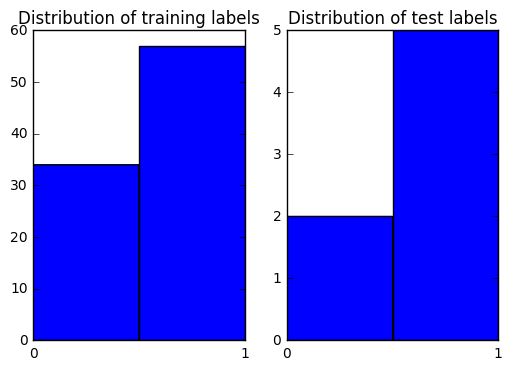

In [6]:
# compare distribution of labels in training and test sets
fig,ax = plt.subplots(1, 2)
ax[0].hist(y_train, bins=2);
#ax[0].tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
ax[0].set_xticks([0,1])
ax[0].set_title('Distribution of training labels')
ax[1].hist(y_test, bins=2);
#ax[1].tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
ax[1].set_xticks([0,1])
ax[1].set_title('Distribution of test labels');

In [222]:
# helpers functions
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),scoring='f1_score'):
    """
    Plot the learning curve for an estimator
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plot the confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def model_selector(n_runs=10, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, *args):
    """
    Compare test performances for a range of models
    """
    print(len(args), 'models chosen')
    for model in args:
        f1_scores = []
        accuracies = []
        print('\nModel:', type(model))
        for i in range(n_runs):
            #X_train, y_train = shuffle(X_train, y_train, random_state=0)
            model.fit(X_train, y_train)
            y_preds = model.predict(X_test)
            f1_scores.append(f1_score(y_test, y_preds))
            accuracies.append(accuracy_score(y_test, y_preds))
        print('\n\nF1 scores: ', np.round(f1_scores, decimals=2))
        print('\n\nmean / std: %.2f / %.2f' % (np.mean(f1_scores), np.std(f1_scores)))
        print('\n\naccuracies: ', np.round(accuracies, decimals=2))
        print('\n\nmean / std: %.2f / %.2f' % (np.mean(accuracies), np.std(accuracies)))

## Random forest

In [8]:
# perform grid-search cross-validation to select hyperparameters
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [5, 10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [None, 5, 10, 20]
}
CV_rf = GridSearchCV(rf, param_grid, scoring='accuracy', cv=5, verbose=1)
CV_rf.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:   47.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20, 30, 40, 50], 'max_depth': [None, 5, 10, 20], 'max_features': ['auto', 'sqrt', 'log2', None], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [367]:
print('Best score obtained: ', CV_rf.best_score_,'\nwith parameters: ', CV_rf.best_params_)

Best score obtained:  0.747252747253 
with parameters:  {'max_depth': 20, 'n_estimators': 40, 'max_features': 'log2', 'criterion': 'gini'}


In [10]:
# plot feature importance
best_rf = CV_rf.best_estimator_
importances = best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
cols = train_seasons.drop(['Opponent 0', 'Winner', 'Year', 'Opponent 1'], axis=1).columns
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature GF (0.062078)
2. feature PP% (0.053995)
3. feature PKT (0.045135)
4. feature GF even (0.044779)
5. feature PK SI/GP (0.044345)
6. feature GF/GP (0.042876)
7. feature GA even (0.039975)
8. feature GA even/GP (0.038281)
9. feature GA (0.037307)
10. feature PK GA (0.037047)
11. feature PPT (0.036261)
12. feature GF even/GP (0.031306)
13. feature PK GA/GP (0.030204)
14. feature PP OP/GP (0.030100)
15. feature PK GF/GP (0.030088)
16. feature 2'  (0.030024)
17. feature PK% (0.029971)
18. feature PK time/GP (0.027870)
19. feature PP OP (0.027135)
20. feature PP time/GP (0.026267)
21. feature GA/GP (0.025072)
22. feature PPG/GP (0.024404)
23. feature PK SI (0.020139)
24. feature SHG (0.019372)
25. feature PP GA/GP (0.018800)
26. feature PPG (0.018688)
27. feature SOWGF (0.018302)
28. feature 10' (0.017764)
29. feature PIM Total (0.017604)
30. feature PP GA (0.016760)
31. feature 5' (0.016379)
32. feature SOWGA (0.014720)
33. feature MP (0.012962)
34. feature GM (0.0

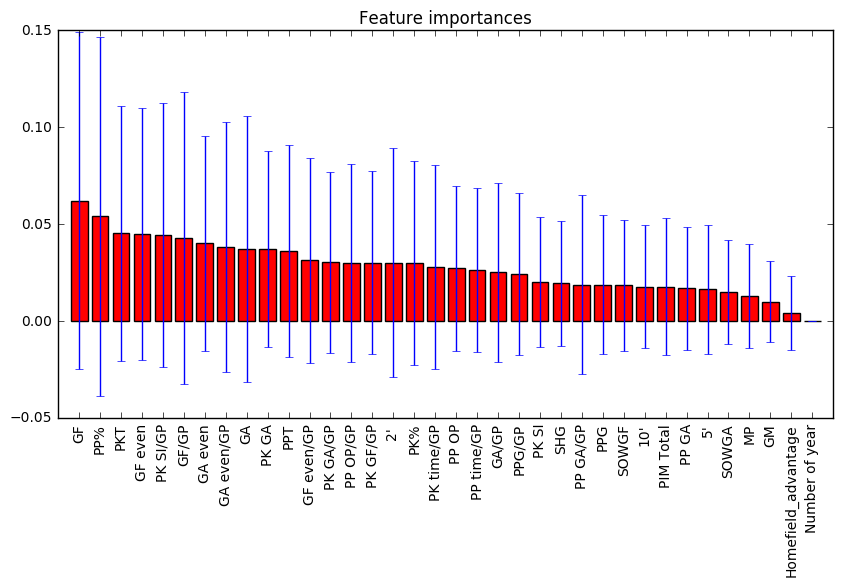

In [11]:
# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices],  align='center')
plt.xticks(range(X_train.shape[1]), cols[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [12]:
# subset of data based on feature importance
restricted_feature_set = cols[indices[0:-2]]
restricted_data = train_seasons[restricted_feature_set]
X_train_restricted = restricted_data.as_matrix()
X_train_restricted_norm = MinMaxScaler().fit_transform(X_train_restricted)

## MLP Classifier 

In [131]:
# perform grid-search cross-validation to select hyperparameters
param_grid = {
    'solver':['lbfgs'],
    'hidden_layer_sizes':[(10,),(30,), (50,), (80,), (100,),(10,10), (50,50)],
    'activation': ['logistic'],
    'early_stopping': [True, False],
    'alpha': np.logspace(-1, 1, num=10),
    'max_iter': [500, 1000, 2000],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
    
}
clfncv = MLPClassifier()
cv_mlp = GridSearchCV(clfncv, param_grid, scoring='accuracy', cv=5, verbose=1)
cv_mlp.fit(X_train_norm,y_train)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=1)]: Done 6300 out of 6300 | elapsed:  9.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'solver': ['lbfgs'], 'activation': ['logistic'], 'early_stopping': [True, False], 'hidden_layer_sizes': [(10,), (30,), (50,), (80,), (100,), (10, 10), (50, 50)], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'max_iter': [500, 1000, 2000], 'alpha': array([  0.1    ,   0.16681,   0.27826,   0.46416,   0.77426,   1.29155,
         2.15443,   3.59381,   5.99484,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [132]:
print('Best score obtained: ', cv_mlp.best_score_,'\nwith parameters: ', cv_mlp.best_params_)

Best score obtained:  0.692307692308 
with parameters:  {'activation': 'logistic', 'solver': 'lbfgs', 'early_stopping': True, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'max_iter': 2000, 'alpha': 0.46415888336127786}


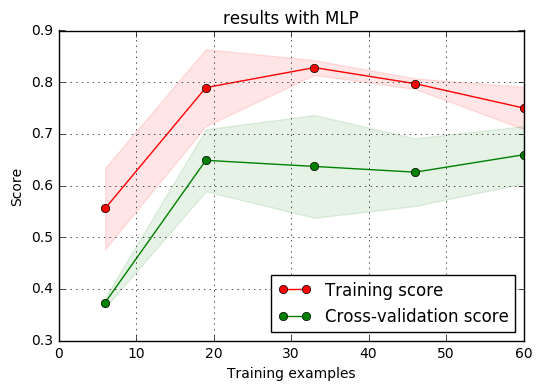

In [135]:
best_nn = cv_mlp.best_estimator_
plot_learning_curve(best_nn, 'results with MLP', X_train_norm, y_train, scoring='accuracy');

## SVM

In [171]:
# perform grid-search cross-validation to select hyperparameters
svm_model = svm.SVC()
param_grid = {
    'C': np.logspace(-2, 2, 5),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5],
    'gamma': np.logspace(-3, 2, 6),
    'probability': [True],
    'max_iter': [100000]
}
cv_svm = GridSearchCV(svm_model, param_grid, scoring='roc_auc', n_jobs=1, cv=5, verbose=2)
cv_svm.fit(X_train_norm, y_train) 

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001, total=   0.0s
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001, total=   0.0s
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001, total=   0.0s
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001, total=   0.0s
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.001, total=   0.0s
[

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=sigmoid, gamma=0.01, total=   0.0s
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=sigmoid, gamma=0.01 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=sigmoid, gamma=0.01, total=   0.0s
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=sigmoid, gamma=0.01 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=sigmoid, gamma=0.01, total=   0.0s
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.1 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.1, total=   0.0s
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.1 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.1, total=   0.0s
[CV] probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, gamma=0.1 
[CV]  probability=True, C=0.01, degree=3, max_iter=100000, kernel=linear, g

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   14.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'probability': [True], 'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'degree': [3, 4, 5], 'max_iter': [100000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=2)

In [172]:
print('Best score obtained: ', cv_svm.best_score_,'\nwith parameters: ', cv_svm.best_params_)

Best score obtained:  0.744481708767 
with parameters:  {'probability': True, 'C': 10.0, 'degree': 3, 'max_iter': 100000, 'kernel': 'sigmoid', 'gamma': 0.10000000000000001}


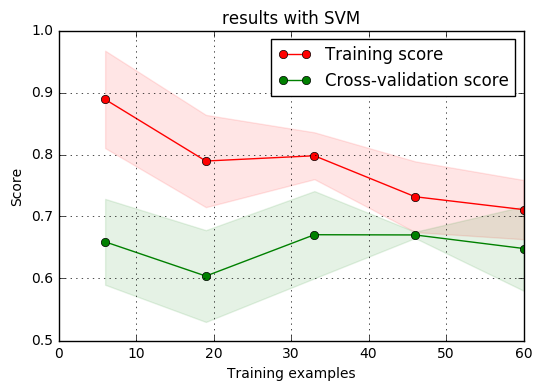

In [176]:
best_svm = cv_svm.best_estimator_
plot_learning_curve(best_svm, 'results with SVM', X_train_norm, y_train, scoring='accuracy');
plt.savefig('learning_curve.png')

Confusion matrix, without normalization
[[2 0]
 [3 2]]


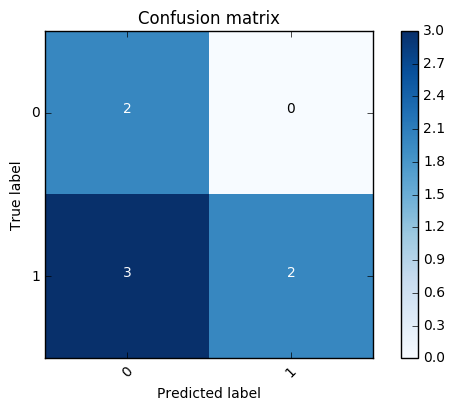

In [141]:
y_preds = best_svm.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_preds), classes=[0,1])

### Logistic regression

In [142]:
# perform grid-search cross-validation to select hyperparameters
log_reg = LogisticRegression()
param_grid = {
    'penalty': ['l2'],
    'C': np.logspace(-3,2,6),
    'max_iter': [1000000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
}
CV_log_reg = GridSearchCV(log_reg, param_grid, scoring='accuracy', cv=5, verbose=1)
CV_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   29.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'], 'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02]), 'penalty': ['l2'], 'max_iter': [1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [321]:
print('Best score obtained: ', CV_log_reg.best_score_,'\nwith parameters: ', CV_log_reg.best_params_)

Best score obtained:  0.659340659341 
with parameters:  {'solver': 'sag', 'C': 0.001, 'penalty': 'l2', 'max_iter': 1000000}


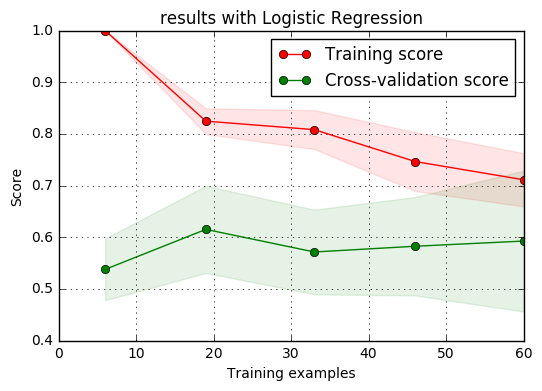

In [322]:
best_log_reg = CV_log_reg.best_estimator_
plot_learning_curve(best_log_reg, 'results with Logistic Regression', X_train, y_train, scoring='accuracy');

## Naive Bayes Classifier

In [330]:
# some tests with naive bayes classifier
#gaussian_nb = naive_bayes.BernoulliNB(class_prior=[35,55])
#gaussian_nb = naive_bayes.GaussianNB(priors=[58/91, 33/91])
gaussian_nb = naive_bayes.GaussianNB(priors=[0.1, 0.9])
cross_val_score(gaussian_nb, X_train, y_train, scoring='accuracy', cv=5)

array([ 0.73684211,  0.63157895,  0.61111111,  0.61111111,  0.58823529])

In [326]:
best_log_reg.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000000, multi_class='ovr',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [328]:
best_log_reg.predict(X_test)

array([0, 1, 0, 0, 0, 0, 1])

In [61]:
test_season_lna

,Homefield_advantage,Opponent 0,Winner,Year,Opponent 1,GF,PK SI,PK SI/GP,PK GA,PK GA/GP,...,10',GM,MP,PIM Total,PP OP,PP OP/GP,PP%,PPT,PP time/GP,Number of year
Series_ID,,,,,,,,,,,,,,,,,,,,,
1516_EV Zug HC Lugano,1,EV Zug,1,1516,HC Lugano,4.0,9.0,0.18,1.0,0.02,...,3.0,0.0,0.0,28.0,6.0,0.12,5.65,598.0,12.0,0.0
1516_Fribourg-Gottéron Genève-Servette HC,1,Fribourg-Gottéron,1,1516,Genève-Servette HC,-12.0,-42.0,-0.84,6.0,0.12,...,0.0,1.0,0.0,-31.0,22.0,0.44,-4.84,1069.0,21.0,0.0
1516_Genève-Servette HC HC Lugano,1,Genève-Servette HC,1,1516,HC Lugano,3.0,28.0,0.56,2.0,0.04,...,4.0,-1.0,0.0,42.0,-14.0,-0.28,8.74,-1173.0,-23.0,0.0
1516_HC Davos Kloten Flyers,0,HC Davos,0,1516,Kloten Flyers,27.0,22.0,0.44,-13.0,-0.26,...,7.0,5.0,0.0,238.0,17.0,0.34,-3.26,934.0,19.0,0.0
1516_HC Davos SC Bern,0,HC Davos,1,1516,SC Bern,29.0,0.0,0.00,-11.0,-0.22,...,3.0,3.0,0.0,58.0,-36.0,-0.72,-5.31,-2058.0,-41.0,0.0
1516_HC Lugano SC Bern,0,HC Lugano,1,1516,SC Bern,5.0,-11.0,-0.22,-4.0,-0.08,...,-6.0,3.0,0.0,-30.0,-23.0,-0.46,-7.66,-1329.0,-27.0,0.0
1516_SC Bern ZSC Lions,1,SC Bern,0,1516,ZSC Lions,-21.0,20.0,0.40,1.0,0.02,...,6.0,1.0,0.0,174.0,33.0,0.66,-1.08,2461.0,49.0,0.0


In [62]:
best_svm.predict_proba(X_test)

array([[ 0.36504812,  0.63495188],
       [ 0.40374337,  0.59625663],
       [ 0.37476948,  0.62523052],
       [ 0.33252155,  0.66747845],
       [ 0.38445434,  0.61554566],
       [ 0.36504812,  0.63495188],
       [ 0.37476948,  0.62523052]])

In [181]:
best_rf.fit(X_train, y_train)
preds = best_rf.predict(X_test)

In [182]:
accuracy_score(y_test, preds)

0.7142857142857143